In [62]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV 

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
data = pd.read_csv('data.csv')

In [64]:
#to caculate the sum of different action type such as jump shot or running jump shot
total_actions = dict(data.action_type.value_counts())

'''threshold = 10
data['type'] = data.apply(lambda row: row['action_type'] if total_actions[row['action_type']] >= threshold \
                          else row['combined_shot_type'], axis = 1)'''

data['time_remaining'] = data.apply(lambda row: row['minutes_remaining']*60 + row['seconds_remaining'], axis = 1)

# TODO: tune this parameter
threshold = 5
# TODO: find out why he cant hit @ 14 secs to go
#anomaly = 5

#data['last moment'] = data.apply(lambda row: row['time_remaining'] <= threshold or row['time_remaining'] == anomaly, 
#                                axis = 1)
data['last moment'] = data.apply(lambda row: row['time_remaining'] <= threshold, 
                                 axis = 1)
#data['shot_distance'] = data.apply(lambda row: 28 if row['shot_distance']>28 else row['shot_distance'], axis=1)

In [65]:
data

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,time_remaining,last moment
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1,627,False
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2,622,False
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3,465,False
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4,412,False
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5,379,False
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6,572,False
6,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,3,...,Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,7,532,False
7,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,...,Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,8,485,False
8,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,3,...,In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,9,372,False
9,Running Jump Shot,Jump Shot,294,20000012,33.9193,-33,125,-118.3028,3,3,...,In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,10,216,False


In [66]:
def get_acc(data, field):
    ct = pd.crosstab(data.shot_made_flag, data[field]).apply(lambda x: x / x.sum(), axis=0)
    x, y = ct.columns, ct.values[1, :]
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    plt.xlabel(field)
    plt.ylabel('% shots made')
    plt.show()

In [67]:
def sort_encode(data, field):
    ct = pd.crosstab(data.shot_made_flag, data[field]).apply(lambda x: x / x.sum(), axis=0)
    temp = list(zip(ct.values[1, :], ct.columns))
    temp.sort()
    new_map = {}
    for index, (acc, old_number) in enumerate(temp):
        new_map[old_number] = index
    new_field = field + '_sort_enumerated'
    data[new_field] = data[field].map(new_map)
    get_acc(data, new_field)

In [68]:

'''
data.drop([
        'action_type',
        'combined_shot_type',
        'game_event_id',
        'game_id',
        #'lat',
        #'lon',
        'minutes_remaining',
        'seconds_remaining',
        'time_remaining',
        'team_id',
        'team_name',
        'matchup',
        'game_date',
        'shot_type',
        'playoffs',
        'season',
        # TODO: find out whether these two features matter or not
        #'loc_x',
        #'loc_y',
    ], axis=1, inplace=True)'''

data.drop([
        #'lat',
        #'lon',
        'minutes_remaining',
        'seconds_remaining',
        'game_id',
        'game_event_id',
        'game_date',#TODO: check if it's needed
        #'time_remaining',
        # TODO: find out whether these two features matter or not
        #'loc_x',
        #'loc_y',
        'opponent',
        #'matchup', 
        #'combined_shot_type',
    ], axis=1, inplace=True)

dummies = [
    'period',
    #'type',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range',
    #'opponent',
    'team_id',
    'team_name',
    'matchup',
    #'game_date',
    'shot_type',
    'playoffs',
    'season',
    'action_type',
    'combined_shot_type',
 #   'game_event_id',
]
dummie_counter = {}
for dummy in dummies:
    dummie_counter[dummy] = len(data[dummy].unique())
data = pd.get_dummies(data, columns=dummies)


# In[27]:

dummie_counter

{'action_type': 57,
 'combined_shot_type': 6,
 'matchup': 74,
 'period': 7,
 'playoffs': 2,
 'season': 20,
 'shot_type': 2,
 'shot_zone_area': 6,
 'shot_zone_basic': 7,
 'shot_zone_range': 5,
 'team_id': 1,
 'team_name': 1}

In [69]:
data.head()

,lat,loc_x,loc_y,lon,shot_distance,shot_made_flag,shot_id,time_remaining,last moment,period_1,...,action_type_Turnaround Fadeaway shot,action_type_Turnaround Finger Roll Shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot
0,33.9723,167,72,-118.1028,18,NaN,1,627,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,34.0443,-157,0,-118.4268,15,0.0,2,622,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,33.9093,-101,135,-118.3708,16,1.0,3,465,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,33.8693,138,175,-118.1318,22,0.0,4,412,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,34.0443,0,0,-118.2698,0,1.0,5,379,False,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [70]:
# split into train and test
train = data[~data['shot_made_flag'].isnull()]
test = data[data['shot_made_flag'].isnull()]
print('train size: ' + str(len(train)))
print('test size:  ' + str(len(test)))

# prepare data for estimators
target = 'shot_made_flag'
features = data.columns.tolist()
features.remove(target)
features.remove('shot_id')
X_test = test[features]
X_train = train[features]
y_train = train[[target]]['shot_made_flag'].values
print(X_train.shape)
print(y_train.shape)

train size: 25697
test size:  5000
(25697, 195)
(25697,)


In [71]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds, metrics=['logloss'])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Test params
    X_train, X_valid, y_train, y_valid = train_test_split(dtrain[predictors], dtrain[target], test_size=0.2)
    alg.fit(X_train, y_train, eval_metric='logloss')
    y_pred = alg.predict_proba(X_valid)[:,1]
    
    result = log_loss(y_valid, y_pred)
    print(result)
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    plt.figure(figsize=(50,10))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return result

In [72]:
params = {
    'base_score': 0.5, 
    'colsample_bylevel': 1,
    'colsample_bytree': 0.8,
    'learning_rate': 0.035,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 200,
    'nthread': 8,
    'objective': 'binary:logistic',
    'seed': 2,
    'subsample': 0.8
}




Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 107


0.598165226322


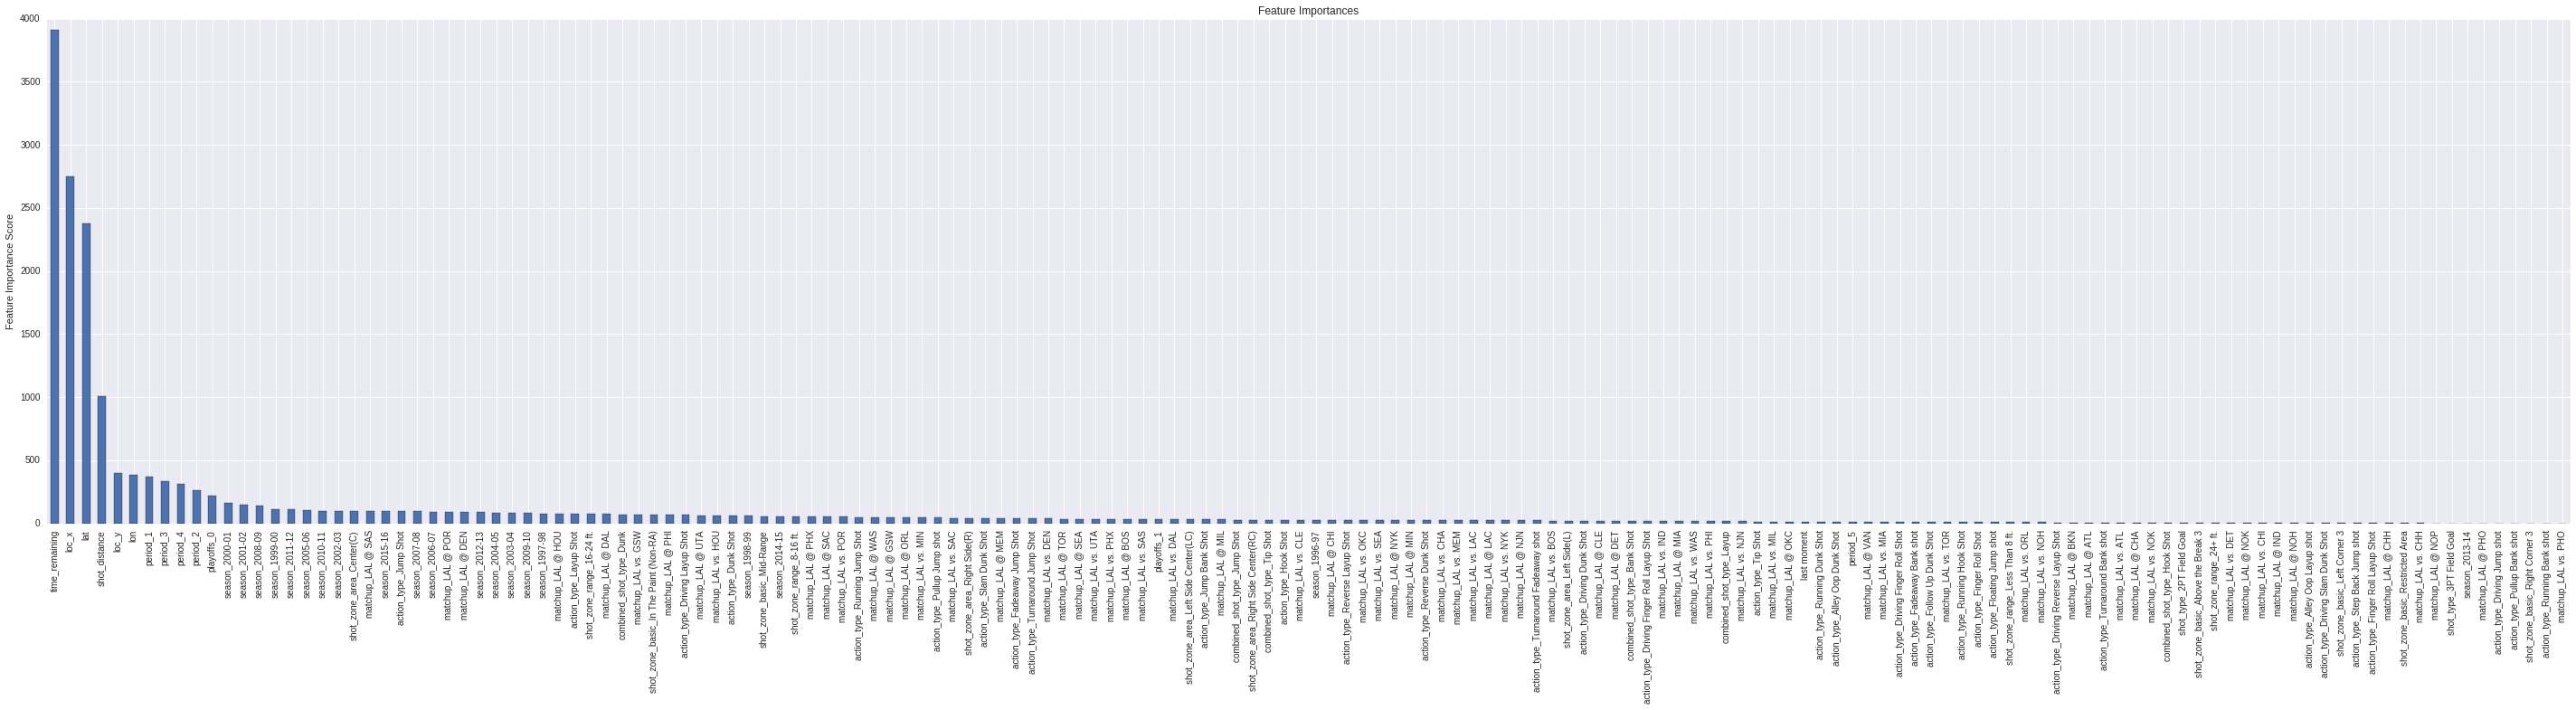

In [73]:
clf = xgb.XGBClassifier()
clf.set_params(**params)


predictors = [x for x in X_train.columns if x not in target]
result = modelfit(clf,train,predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50)

s_result = []
s_result = s_result.append(result)
s_result = pd.Series(result)
s_result.to_csv("predict_result_xgb.csv")


clf.fit(X_train, y_train)

test.shot_made_flag = [i[1] for i in clf.predict_proba(X_test)]

test[['shot_id', 'shot_made_flag']].to_csv('sub.csv', index=False)
predictions_train = clf.predict_proba(X_train)
features_train = pd.DataFrame({'shot_made_flag': predictions_train[:, 1]})
features_train[['shot_made_flag']].to_csv('features_train.csv', index=False)


# In[ ]:

In [74]:
clf.fit(X_train, y_train)

test.shot_made_flag = [i[1] for i in clf.predict_proba(X_test)]

test[['shot_id', 'shot_made_flag']].to_csv('sub.csv', index=False)
predictions_train = clf.predict_proba(X_train)
features_train = pd.DataFrame({'shot_made_flag': predictions_train[:, 1]})
features_train[['shot_made_flag']].to_csv('features_train.csv', index=False)
print("results have been written!")

In [ ]:
param_test1 = [{
 'max_depth':[9,11,13],
 'min_child_weight':[1,3]
}]
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.03, n_estimators=200,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=2), 
                        param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

gsresult = [gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_]

print gsresult
gs_result = pd.Series(gsresult)
gs_result.to_csv("gs_result_xgb.csv")